In [30]:
#Import Libraries

In [31]:
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from openpyxl import load_workbook


In [32]:
#Import ML models

In [33]:
from sklearn import linear_model
from sklearn.svm import SVR



#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Lasso
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import ElasticNet
#from sklearn.linear_model import HuberRegressor
#from sklearn.linear_model import Lars
#from sklearn.linear_model import LassoLars
#from sklearn.linear_model import PassiveAggressiveRegressor
#from sklearn.linear_model import RANSACRegressor
#from sklearn.linear_model import SGDRegressor

#from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import AdaBoostRegressor
#from sklearn.neural_network import MLPRegressor
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.tree import DecisionTreeRegressor


In [34]:
#Import Error Metrics

In [35]:
from sklearn.metrics import r2_score

In [126]:
#Read in datafile

In [127]:
df_LSOA_Location_Energy_Sales = pd.read_csv('1_DataCleaning/LSOA_Location_Energy_Sales.csv')

In [128]:
#Split df_LSOA_EnergyConsumption_ResPropertySales dataset 80:20

In [129]:
msk = np.random.rand(len(df_LSOA_Location_Energy_Sales)) < 0.8

In [130]:
train = df_LSOA_Location_Energy_Sales[msk]
test = df_LSOA_Location_Energy_Sales[~msk]

In [131]:
#First pass Robust linear model estimation using RANSAC

In [132]:
lr = linear_model.LinearRegression()

In [133]:
train_x = np.asanyarray(train[['Mean_price_paid']])
train_y = np.asanyarray(train[['Mean_domestic_electricity_consumption_kWh_per_meter']])

In [134]:
train_x.shape

(247979, 1)

In [135]:
train_y.shape

(247979, 1)

In [136]:
train_y = np.squeeze(train_y)

In [137]:
train_y.shape

(247979,)

In [138]:
# Fit line using all data
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [139]:
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(train_x, train_y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

In [140]:
# Predict data of estimated models
line_X = np.arange(train_x.min(), train_x.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

In [141]:
line_X.shape

(9178978, 1)

In [142]:
line_y.shape

(9178978,)

In [143]:
line_y_ransac.shape

(9178978,)

In [144]:
# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac.estimator_.coef_)

Estimated coefficients (true, linear regression, RANSAC):
[0.00168252] [0.0016127]


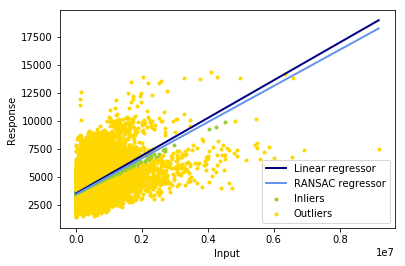

In [145]:
lw = 2
plt.scatter(train_x[inlier_mask], train_y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(train_x[outlier_mask], train_y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

In [146]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(line_y_ransac - line_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((line_y_ransac - line_y) ** 2))
print("R2-score: %.2f" % r2_score(line_y , line_y_ransac) )

Mean absolute error: 409.65
Residual sum of squares (MSE): 202040.49
R2-score: 0.99


In [147]:
MAE = np.mean(np.absolute(line_y_ransac - line_y))
MSE = np.mean((line_y_ransac - line_y) ** 2)
RMSE = np.sqrt(MSE)
R2 = r2_score(line_y , line_y_ransac)


print("Mean absolute error (MAE): %.2f" % MAE)
print("Residual sum of squares (MSE): %.2f" % MSE)
print("Root Residual sum of squares (RMSE): %.2f" % RMSE)
print("R2-score: %.2f" % R2)

Mean absolute error (MAE): 409.65
Residual sum of squares (MSE): 202040.49
Root Residual sum of squares (RMSE): 449.49
R2-score: 0.99


In [148]:
#END